In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Roberta Base Model

In [2]:
import os
import pandas as pd
import numpy as np
import torch

In [3]:
# setting the model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'


# setting the checkpoint path 
if os.path.exists('ckpts'):
    CHECKPOINTPATH = 'ckpts/Persnality_MBTI'
else:
    CHECKPOINTPATH = '../ckpts/Persnality_MBTI'

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)
torch.cuda.manual_seed_all(99)
np.random.seed(99)

In [4]:
CHECKPOINTPATH

'../ckpts/Persnality_MBTI'

#### Load the model

In [5]:
# import model
import sys
sys.path.append('../Models')
import roberta_mbti as model


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/omarahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
roberta_model = model.ROBERTAClass(PRE_TRAINED_MODEL_NAME)
roberta_model.load_state_dict(torch.load(CHECKPOINTPATH + f'_clean_Best_{PRE_TRAINED_MODEL_NAME}.bin', map_location=torch.device(device)))
roberta_model.to(device)
print(f'{PRE_TRAINED_MODEL_NAME}_no_words loaded')
roberta_model.eval()

torch.set_grad_enabled(False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta-base_no_words loaded


### Load Data

In [7]:
all_tweets_df=pd.read_csv('./data/tweets_uncleaned.csv')
elon_tweets_df=all_tweets_df[all_tweets_df['author']=='elonmusk']
elon_tweets_df=elon_tweets_df.reset_index(drop=True)
bill_gates_tweets_df=all_tweets_df[all_tweets_df['author']=='BillGates']
bill_gates_tweets_df=bill_gates_tweets_df.reset_index(drop=True)
edlee_tweets_df=all_tweets_df[all_tweets_df['author']=='mayoredlee']
edlee_tweets_df=edlee_tweets_df.reset_index(drop=True)

In [8]:
print(f'Elon Musk Tweets: {elon_tweets_df.shape}')
print(f'Bill Gates Tweets: {bill_gates_tweets_df.shape}')
print(f'Ed Lee Tweets: {edlee_tweets_df.shape}')

Elon Musk Tweets: (1832, 3)
Bill Gates Tweets: (2060, 3)
Ed Lee Tweets: (2403, 3)


In [9]:
elon_predictions=roberta_model.getPrediction(elon_tweets_df['tweets'].to_list())

In [10]:
elon_predictions

tensor([[0.8831, 0.0170, 0.0250, 0.2009],
        [0.1805, 0.0644, 0.5008, 0.4542],
        [0.1724, 0.0478, 0.0770, 0.6165],
        ...,
        [0.2714, 0.0433, 0.0673, 0.7551],
        [0.3745, 0.0878, 0.3200, 0.5350],
        [0.9520, 0.0204, 0.0154, 0.0247]])

In [11]:
elon_predictions=elon_predictions.round()
elon_predictions

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]])

In [12]:
def measure_traits_presence(predictions,print_out=True):
    # Count the number of ones (1s) along each column (dimension 0)
    ones_count = torch.sum(predictions, dim=0)
    # Count the number of zeros (0s) along each column (dimension 0)
    zeros_count = predictions.size(0) - ones_count
    # Calculate the percentage of ones and zeros for each trait
    ones_precentage=ones_count/predictions.size(0)
    zeros_precentage=zeros_count/predictions.size(0)
    # Round the percentage to 2 decimal places and multiply by 100 to get the percentage
    ones_precentage=(torch.round(ones_precentage,decimals=2)*100).round()  
    zeros_precentage=(torch.round(zeros_precentage,decimals=2)*100).round()  
    if print_out:
        print("Introvert(0) vs Extrovert(1):", zeros_precentage[0].item(),"% vs", ones_precentage[0].item(),"%")
        print("Intuition(0) vs Sensing(1):", zeros_precentage[1].item(),"% vs", ones_precentage[1].item(),"%")
        print("Thinking(0) vs Feeling(1):", zeros_precentage[2].item(),"% vs", ones_precentage[2].item(),"%")
        print("Judging(0) vs Perceiving(1):", zeros_precentage[3].item(),"% vs", ones_precentage[3].item(),"%")

    return ones_precentage,zeros_precentage

In [13]:
#example
tensor_data = torch.tensor([[1., 0., 0., 0.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.],
                            [0., 0., 0., 1.],
                            [0., 0., 0., 1.],
                            [1., 0., 0., 0.]])
measure_traits_presence(tensor_data)
# Ones count per column: [2.0, 0.0, 1.0, 3.0]
# Zeros count per column: [4.0, 6.0, 5.0, 3.0]

Introvert(0) vs Extrovert(1): 67.0 % vs 33.0 %
Intuition(0) vs Sensing(1): 100.0 % vs 0.0 %
Thinking(0) vs Feeling(1): 83.0 % vs 17.0 %
Judging(0) vs Perceiving(1): 50.0 % vs 50.0 %


(tensor([33.,  0., 17., 50.]), tensor([ 67., 100.,  83.,  50.]))

In [14]:
measure_traits_presence(elon_predictions)

Introvert(0) vs Extrovert(1): 96.0 % vs 4.0 %
Intuition(0) vs Sensing(1): 96.0 % vs 4.0 %
Thinking(0) vs Feeling(1): 94.0 % vs 6.0 %
Judging(0) vs Perceiving(1): 28.0 % vs 72.0 %


(tensor([ 4.,  4.,  6., 72.]), tensor([96., 96., 94., 28.]))

In [15]:
bgates_predictions=roberta_model.getPrediction(bill_gates_tweets_df['tweets'].to_list())
bgates_predictions=bgates_predictions.round()
bgates_predictions

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.]])

In [16]:
measure_traits_presence(bgates_predictions)

Introvert(0) vs Extrovert(1): 98.0 % vs 2.0 %
Intuition(0) vs Sensing(1): 100.0 % vs 0.0 %
Thinking(0) vs Feeling(1): 81.0 % vs 19.0 %
Judging(0) vs Perceiving(1): 36.0 % vs 64.0 %


(tensor([ 2.,  0., 19., 64.]), tensor([ 98., 100.,  81.,  36.]))

In [17]:
edlee_predictions=roberta_model.getPrediction(edlee_tweets_df['tweets'].to_list())
edlee_predictions=edlee_predictions.round()
edlee_predictions

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [18]:
measure_traits_presence(edlee_predictions)

Introvert(0) vs Extrovert(1): 99.0 % vs 1.0 %
Intuition(0) vs Sensing(1): 99.0 % vs 1.0 %
Thinking(0) vs Feeling(1): 73.0 % vs 27.0 %
Judging(0) vs Perceiving(1): 58.0 % vs 42.0 %


(tensor([ 1.,  1., 27., 42.]), tensor([99., 99., 73., 58.]))

### Analyze Extracted Traits

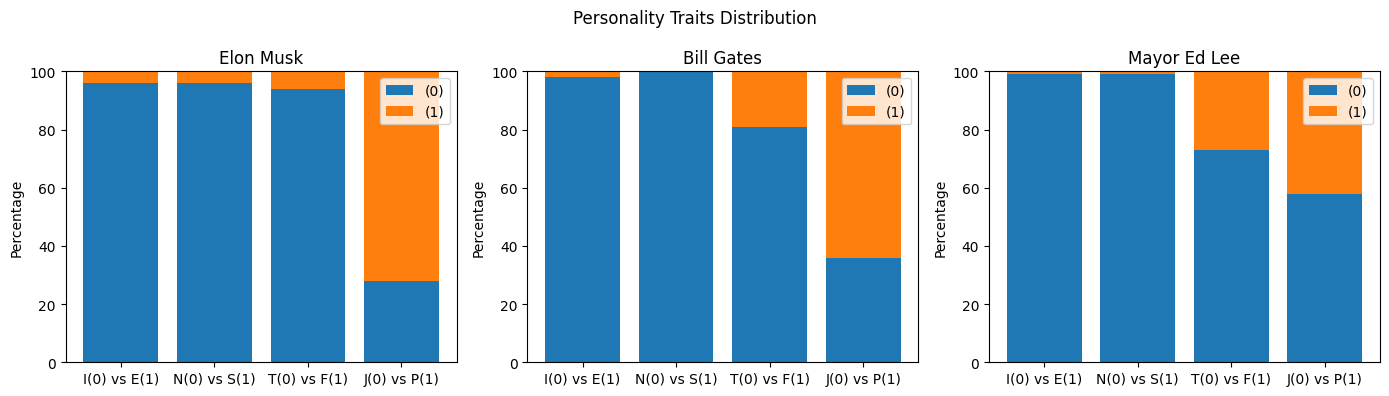

In [19]:
import matplotlib.pyplot as plt

def plot(predictions_list, labels, names):
    fig, axs = plt.subplots(1, 3, figsize=(14,4))
    axs = axs.flatten()
    fig.suptitle('Personality Traits Distribution')
    
    for i, predictions in enumerate(predictions_list):
        # Round the percentages to two decimal places
        ones_percentage_rounded,zeros_percentage_rounded =measure_traits_presence(predictions,print_out=False)
        
        # Plotting
        ax = axs[i]
        ax.bar(labels, zeros_percentage_rounded.tolist(), label='(0)')
        ax.bar(labels, ones_percentage_rounded.tolist(), bottom=zeros_percentage_rounded.tolist(), label='(1)')
        ax.set_ylim([0, 100])  # Set y-axis limit from 0 to 1
        ax.set_ylabel('Percentage')
        ax.set_title(names[i])
        ax.legend()
        # flip the x-axis labels
        
    
    plt.tight_layout()
    plt.show()

# Example usage
predictions_list = [elon_predictions, bgates_predictions, edlee_predictions]
labels = ['I(0) vs E(1)', 'N(0) vs S(1)', 'T(0) vs F(1)', 'J(0) vs P(1)']
plot(predictions_list, labels,['Elon Musk','Bill Gates','Mayor Ed Lee'])
